# Programming Assignment 2

### Imports

In [1]:
import gym
from duelingDQN import dqn, DuelingDQNAgent
import matplotlib.pyplot as plt
from vars import *

ENVS = [HyperEnv('CartPole-v1',1000, 1000, 64, 1e-4, 100, 0.99, 1, 128, 64), HyperEnv('Acrobot-v1', 300, 500, 256, 1e-3, 500, 0.99, 0.1, 128, 256)]

## DDQN Cartpole

### Dueling DQN algorithm with mean aggregation on cartpole environment

In [ ]:
cartpole_parameters = ENVS[0]

print(f"\nTraining and evaluating Dueling DQN agent on {cartpole_parameters.name} environment:")
env = gym.make(cartpole_parameters.name)
dueling_dqn_agent_type1 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, 37, "mean", cartpole_parameters)
scores = dqn(dueling_dqn_agent_type1, env, n_episodes=cartpole_parameters.n_episodes, max_t=cartpole_parameters.max_t)
plt.plot(scores)
plt.show()


Training and evaluating Dueling DQN agent on CartPole-v1 environment:
Episode 56	Average Score: 92.30	Number of steps: 165

### Dueling DQN algorithm with max aggregation

Episode 200	Average Score: 86.69	Number of steps: 142
Episode 300	Average Score: 135.41	Number of steps: 165
Episode 400	Average Score: 129.06	Number of steps: 194
Episode 500	Average Score: 116.89	Number of steps: 521
Episode 600	Average Score: 161.43	Number of steps: 174
Episode 700	Average Score: 105.94	Number of steps: 161
Episode 800	Average Score: 137.04	Number of steps: 137
Episode 900	Average Score: 140.94	Number of steps: 294
Episode 1000	Average Score: 101.03	Number of steps: 92


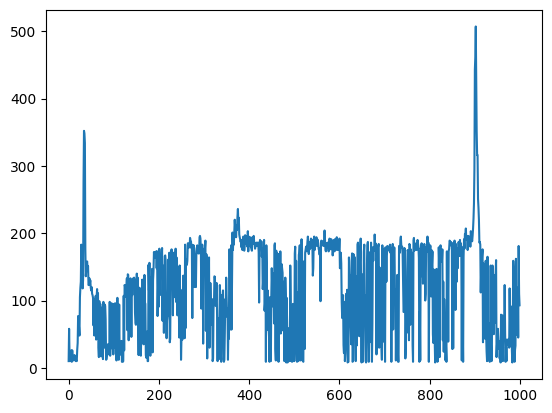

In [3]:
cartpole_parameters = ENVS[0]

print(f"\nTraining and evaluating Dueling DQN agent on {cartpole_parameters.name} environment:")
env = gym.make(cartpole_parameters.name)
dueling_dqn_agent_type1 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, 37, "max", cartpole_parameters)
scores = dqn(dueling_dqn_agent_type1, env, n_episodes=cartpole_parameters.n_episodes, max_t=cartpole_parameters.max_t)
plt.plot(scores)
plt.show()

## DDQN Acrobot

### Dueling DQN algorithm with mean aggregation on Acrobot environment

In [ ]:
acrobot_parameters = ENVS[1]

print(f"\nTraining and evaluating Dueling DQN agent on {ENVS[1].name} environment:")
env = gym.make(acrobot_parameters.name)
dueling_dqn_agent_type1 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, 37, "mean", acrobot_parameters)
scores = dqn(dueling_dqn_agent_type1, env, n_episodes=acrobot_parameters.n_episodes, max_t=acrobot_parameters.max_t)
plt.plot(scores)
plt.show()


Training and evaluating Dueling DQN agent on Acrobot-v1 environment:
Episode 95	Average Score: -151.82	Number of steps: 875

### Dueling DQN algorithm with max aggregation on Acrobot environment

In [ ]:
acrobot_parameters = ENVS[1]

print(f"\nTraining and evaluating Dueling DQN agent on {ENVS[1].name} environment:")
env = gym.make(acrobot_parameters.name)
dueling_dqn_agent_type1 = DuelingDQNAgent(env.observation_space.shape[0], env.action_space.n, 37, "max", acrobot_parameters)
scores = dqn(dueling_dqn_agent_type1, env, n_episodes=acrobot_parameters.n_episodes, max_t=acrobot_parameters.max_t)
plt.plot(scores)
plt.show()

## DDQN Inferences

## REINFORCE cartpole